<a href="https://colab.research.google.com/github/o-fugi/systematicity-semantic-change/blob/main/analysis/Target_Prediction_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# run this cell and then restart the runtime if you want to generate graphs

!pip install matplotlib --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 5.2 MB/s 
     |████████████████████████████████| 965 kB 51.3 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [ ]:
# import packages

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from functools import reduce
import matplotlib.pyplot as plt

In [ ]:
# install sentence-transformers

! pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
from sentence_transformers import util
model = SentenceTransformer('whaleloops/phrase-bert')

In [ ]:
# import semantic shift dataset

shift_class_df = pd.read_csv('../data/cleaned_dat_sem_shift.csv')
shift_class_df['meaning1'] = shift_class_df['meaning1_clean']
shift_class_df['meaning2'] = shift_class_df['meaning2_clean']
shift_class_df = shift_class_df[['meaning1', 'meaning2', 'realizations']]

shift_class_df.at[697, 'meaning1'] = 'furuncul'
shift_class_df.at[1521, 'meaning2'] = 'geometrid'

## PCA

In [ ]:
# create a dictionary for the embeddings
vec_dic = {} # This will be a dictionary that easily allows us to access the embedding for all of our senses, saving time. 
error_senses = set()  # This represents the set of senses for which there was a problem converting them to embeddings or concreteness values

encoding_len = len(model.encode('yikes'))

for i in range(len(shift_class_df)): # Here we loop through each row of our dataframe, and if we can convert a sense s to an embedding then we set vec_dic[s] = embedding
  row = shift_class_df.iloc[i]
  x = row["meaning1"]
  y = row["meaning2"]

  try:   
    if x not in vec_dic:
      xvec = np.array(model.encode(x))
      vec_dic[x] = xvec
  except:
    error_senses.add(x)

  try:  
    if y not in vec_dic:
      yvec = np.array(model.encode(y))
      vec_dic[y] = yvec
  except: 
    error_senses.add(y)

error_senses = list(error_senses) # List of all senses that could not be converted to embeddings. Should be empty right now with phrase BERT
senses = list(vec_dic.keys()) # List of all concepts

sense_indices = {senses[i]:i for i in range(len(senses))} # sense_indices is a dictionary where its keys are senses and its values are the indices for which the senses appear in our list of senses.

In [ ]:
# create dataframe with a pair of embeddings for each shift

all_vars_df = pd.DataFrame()
all_vars_df['meaning1'] = shift_class_df['meaning1']
all_vars_df['meaning2'] = shift_class_df['meaning2']

# #if working with DatSemShift, might be helpful
all_vars_df['realizations'] = shift_class_df['realizations']

# #if working with the English database, these are helpful
# all_vars_df['word'] = shift_class_df['Word']
# all_vars_df['type'] = shift_class_df['Type of change']
# all_vars_df['date'] = shift_class_df['date']
# all_vars_df['pos'] = shift_class_df['POS']

vec_df = pd.DataFrame.from_dict(vec_dic, orient='index').reset_index().rename(columns={'index':'Word'})
vec_meaning_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning1',right_on='Word', how='left'), [all_vars_df, vec_df])
vec_meaning_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning2',right_on='Word', how='left'), [vec_meaning_df, vec_df])
vec_meaning_df = vec_meaning_df.drop(['Word_x', 'Word_y'], axis=1)

In [ ]:
# create dataframe with one difference embedding for each shift

vec_diff_df = pd.DataFrame()

for i in range(encoding_len):
  vec_diff_df[i] = vec_meaning_df[str(i) + "_y"] - vec_meaning_df[str(i) + "_x"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [ ]:
# create dataframe with all shifts and difference vectors 

source_shift_df = reduce(lambda  left,right: pd.merge(left,right,left_index=True,right_index=True, how='left'), [all_vars_df, vec_diff_df])

In [ ]:
# perform pca, just so the gaussian mixture will perform a little better
# x = source_shift_df.drop(['word', 'meaning1', 'meaning2', 'type', 'pos', 'date'], axis=1).values # if working with English database
x = source_shift_df.drop(['meaning1', 'meaning2', 'realizations'], axis=1).values
scaler = StandardScaler()
scaler.fit(x)
x_scale = scaler.transform(x)

n_dimensions = 50

# do PCA
pca = PCA(n_components=n_dimensions)
pca.fit(x_scale)
components = pca.transform(x_scale)
components_df = pd.DataFrame(data = components)#.rename(columns={0:'PC_1' , 1:'PC_2', 2:"PC_3", 3:'PC_4'})

# merge back into word data
df = reduce(lambda  left,right: pd.merge(left,right, left_index=True, right_index=True), [all_vars_df, components_df])

## testing models

In [ ]:
# define prediction models! 

# return the target that's most similar to the source
def get_most_similar(source, potential_targets, train_df, similarity='euclidean'):
  dists = []

  for target in potential_targets:
    diff_vec = vec_dic[target] - vec_dic[source]
    dists.append(np.linalg.norm(diff_vec))

  best_target = np.argmin(dists)
  rank = list(np.argsort(dists)).index(0) + 1

  return rank, best_target

# return the shift that's the most similar to any other shift (this is the "analogy" model)
def get_dist_closest(source, potential_targets, train_df, similarity='euclidean'):
  min_dists = []

  for target in potential_targets:
    diff_vec = vec_dic[target] - vec_dic[source]
    diff_vec_pca = pca.transform(scaler.transform([diff_vec])) # pca transform
    diff_df = pd.DataFrame([diff_vec_pca[0]])
    diff_df = pd.DataFrame(np.repeat(diff_df.values, len(train_df), axis=0), columns=diff_df.columns)

    if similarity=='cosine':
      dists = np.inner(train_df[list(range(n_dimensions))], diff_vec_pca).T / (np.linalg.norm(train_df[list(range(n_dimensions))], axis=1) * np.linalg.norm(diff_df, axis=1))
    else:
      dists = np.linalg.norm(train_df[list(range(n_dimensions))] - diff_df, axis=1)
    # print(source, "->", target, "is similar to", train_df.iloc[np.argmin(dists)][['meaning1', 'meaning2']].values, "with dist", np.min(dists))
    
    min_dists.append(np.min(np.abs(dists)))
  
  best_target = np.argmin(min_dists)
  # print("Best shift is", source, "->", potential_targets[best_target])
  rank = list(np.argsort(min_dists)).index(0) + 1
  
  return rank, best_target


In [ ]:
# define the method of getting a list of targets whose similarity to the source is about the same as the actual target
# e.g., if dist("food", "meat") = 2, then this returns a list of targets whose distance from "food" is about 2

def get_potential_targets(source, target, test_df, similarity_adjusted=True):
  potential_targets = []
  potential_targets.append(target) # the ACTUAL target
  # df_targets = df[df['meaning1']!=source][['meaning2']] # only take elements of the dataframe that don't have source as meaning1 
  df_targets = test_df[test_df['meaning1']!=source][['meaning2']] # we're gonna try just taking targets from the test_df to see if it improves accuracy 
  df_targets = df_targets.drop_duplicates()
  df_targets = df_targets[df_targets['meaning2']!=target]

  if similarity_adjusted: 
    df_targets = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning2',right_on='Word', how='left'), [df_targets, vec_df])
    dists = np.linalg.norm(df_targets[range(encoding_len)] - vec_dic[source], axis=1) # get list of similarities between source and ALL targets
    dists = abs(dists - np.linalg.norm(vec_dic[target] - vec_dic[source])) # ge

    indices = np.argsort(dists)[0:4]

    potential_targets += list(df_targets.iloc[indices]['meaning2']) # take the 4 targets whose similarity to the source is closest to the actual similarity
  else: 
    potential_targets += list(df_targets['meaning2'].sample(n=4)) # take 4 random targets

  return potential_targets

In [ ]:
def test_model(model_function, similarity_adjusted=True, random_state=0, run_once=False, df=df): 
  # keep track of results
  accuracy_list = []
  # mrr_list = []
  # results_df = pd.DataFrame()

  # shuffle shifts dataframe
  df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)

  # run k-fold cross-validation
  k=5
  for i in range(k):
    if run_once: 
      if i != 0:
        continue
    
    # select train and test datasets
    test_df = df.loc[(int(len(df)/k)*i):(int(len(df)/k)*(i+1))]
    train_df = df.drop(test_df.index)
    train_df = train_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)

    # set up columns for keeping track of results 
    test_df['accurate'] = pd.Series(dtype='boolean')
    test_df['target'] = pd.Series(dtype='string')

    num_correct = 0
    # mrr_total = 0

    # run through dataset
    for i in range(len(test_df)):
      row = test_df.iloc[i]
      source = row['meaning1']
      target = row['meaning2']
    
      # make list of potential targets to choose from
      potential_targets = get_potential_targets(source, target, test_df, similarity_adjusted=similarity_adjusted)

      # calculate outcome
      result = model_function(source, potential_targets, train_df) # returns the rank of the actual target and the index of the selected target
      if result[0] == 1:
        num_correct+=1 
      # mrr_total += 1/result[0]

      # test_df['accurate'][i] = (result[0]==1) # true or false, did this predict accurately? 
      # test_df['target'][i] = (potential_targets[result[1]]) # what shift did it predict?

    accuracy_list.append(num_correct/len(test_df))
    # mrr_list.append(mrr_total)

    # results_df = pd.concat([results_df, test_df[['meaning1', 'meaning2', 'realizations', 'accurate', 'target']]])

  accuracy = np.mean(accuracy_list)

  return accuracy

## figure: accuracy with no realization threshold

In [ ]:
accuracy_df = pd.DataFrame()
accuracy_df['Model'] = pd.Series(dtype='string')
accuracy_df['Random'] = pd.Series(dtype='float64')
accuracy_df['Similarity-Adjusted'] = pd.Series(dtype='float64')

# run similarity model with and without similarity adjustment
random_acc = test_model(get_most_similar, run_once=False, similarity_adjusted=False)
sim_acc = test_model(get_most_similar, run_once=False, similarity_adjusted=True)
accuracy_df.loc[0] = ['Similarity', random_acc*100, sim_acc*100]

# run parallelogram model with and without similarity adjustment
random_acc = test_model(get_dist_closest, run_once=False, similarity_adjusted=False)
sim_acc = test_model(get_dist_closest, run_once=False, similarity_adjusted=True)
accuracy_df.loc[1] = ['Analogy', random_acc*100, sim_acc*100]

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

Text(0.5, 1.0, 'Accuracy of Models')

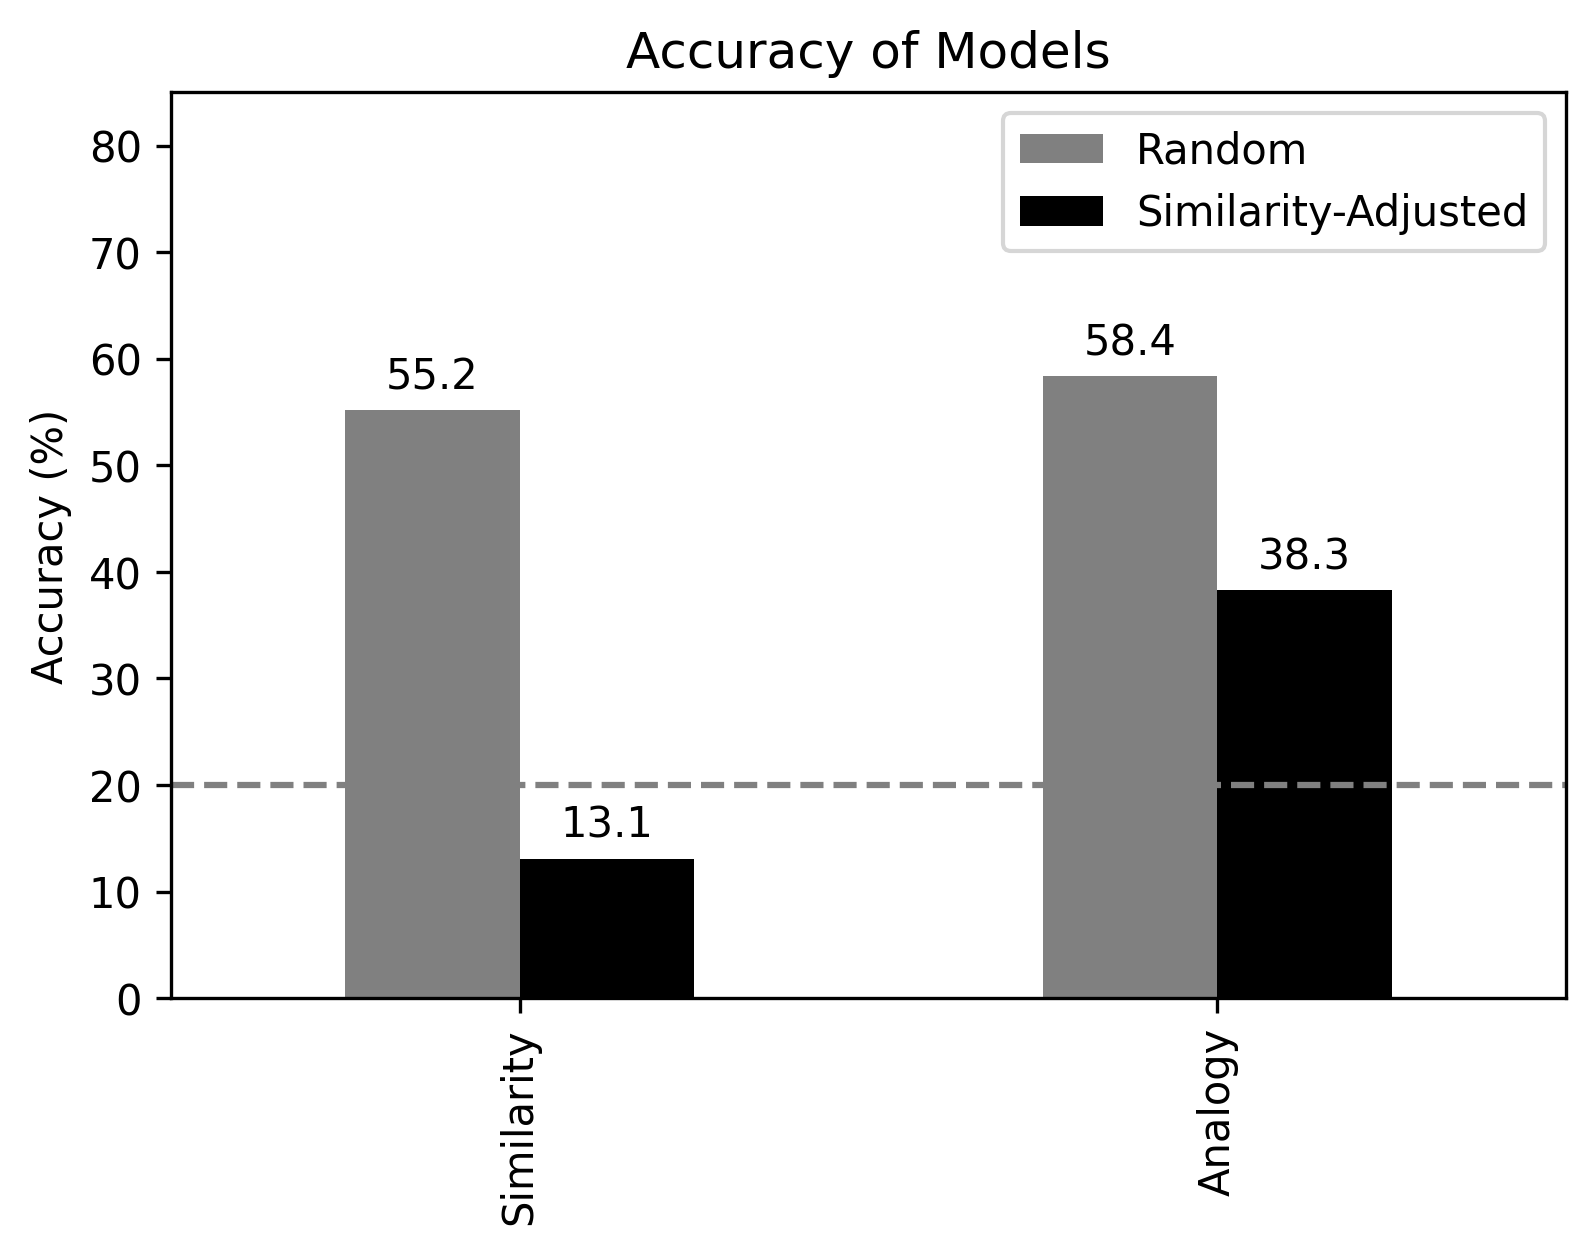

In [ ]:
labels = ['Similarity', 'Analogy']
x=np.arange(len(labels))
accuracy_df = round(accuracy_df, 1)

ax = accuracy_df.plot(kind='bar', color=['gray', 'black'])

## general ax stuff
ax.set_ylim(0, 85)
ax.set_ylabel('Accuracy (%)')

## no filter on realizations

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x, labels=labels)
ax.bar_label(ax.containers[0], padding=3)
ax.bar_label(ax.containers[1], padding=3)
ax.axhline(20, linestyle='--', c='gray')
ax.set_title("Accuracy of Models")
# ax.get_legend().remove()


## figure: accuracy by realization threshold

In [ ]:
# run the models, get the accuracies

accuracy_df = pd.DataFrame()
accuracy_df['Filter'] = pd.Series(dtype='string')
accuracy_df['Model'] = pd.Series(dtype='string')
accuracy_df['Random'] = pd.Series(dtype='float64')
accuracy_df['Similarity-Adjusted'] = pd.Series(dtype='float64')

## NO filter on realizations

# run similarity model with and without similarity adjustment
random_acc = test_model(get_most_similar, run_once=False, similarity_adjusted=False)
sim_acc = test_model(get_most_similar, run_once=False, similarity_adjusted=True)
accuracy_df.loc[0] = ['All pairs', 'Similarity', random_acc*100, sim_acc*100]

# run parallelogram model with and without similarity adjustment
random_acc = test_model(get_dist_closest, run_once=False, similarity_adjusted=False)
sim_acc = test_model(get_dist_closest, run_once=False, similarity_adjusted=True)
accuracy_df.loc[1] = ['All pairs', 'Analogy', random_acc*100, sim_acc*100]

## realizations filtered to be > 1

# run similarity model with and without similarity adjustment
random_acc = test_model(get_most_similar, run_once=False, similarity_adjusted=False, df=df[df['realizations']>1])
sim_acc = test_model(get_most_similar, run_once=False, similarity_adjusted=True, df=df[df['realizations']>1])
accuracy_df.loc[2] = ['Realizations > 1', 'Similarity', random_acc*100, sim_acc*100]

# run parallelogram model with and without similarity adjustment
random_acc = test_model(get_dist_closest, run_once=False, similarity_adjusted=False, df=df[df['realizations']>1])
sim_acc = test_model(get_dist_closest, run_once=False, similarity_adjusted=True, df=df[df['realizations']>1])
accuracy_df.loc[3] = ['Realizations > 1', 'Analogy', random_acc*100, sim_acc*100]

## realizations filtered to be > 5

# run similarity model with and without similarity adjustment
random_acc = test_model(get_most_similar, run_once=False, similarity_adjusted=False, df=df[df['realizations']>5])
sim_acc = test_model(get_most_similar, run_once=False, similarity_adjusted=True, df=df[df['realizations']>5])
accuracy_df.loc[4] = ['Realizations > 5', 'Similarity', random_acc*100, sim_acc*100]

# run parallelogram model with and without similarity adjustment
random_acc = test_model(get_dist_closest, run_once=False, similarity_adjusted=False, df=df[df['realizations']>5])
sim_acc = test_model(get_dist_closest, run_once=False, similarity_adjusted=True, df=df[df['realizations']>5])
accuracy_df.loc[5] = ['Realizations > 5', 'Analogy', random_acc*100, sim_acc*100]

KeyboardInterrupt: ignored

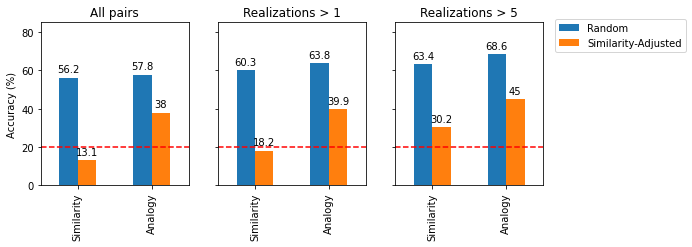

In [ ]:
# create the figure

labels = ['Similarity', 'Analogy']
x=np.arange(len(labels))
accuracy_df = round(accuracy_df, 1)

fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)

## general ax stuff
axs[0].set_ylim(0, 85)
axs[0].set_ylabel('Accuracy (%)')
# fig.suptitle('Accuracy for different realization filters')

## no filter on realizations

axs[0] = accuracy_df[accuracy_df['Filter']=='All pairs'].plot(kind='bar', ax=axs[0])

# Add some text for labels, title and custom x-axis tick labels, etc.
axs[0].set_xticks(x, labels=labels)
axs[0].bar_label(axs[0].containers[0], padding=3)
axs[0].bar_label(axs[0].containers[1], padding=3)
axs[0].axhline(20, linestyle='--', c='r')
axs[0].set_title("All pairs")
axs[0].get_legend().remove()

##  realizations > 1

accuracy_df[accuracy_df['Filter']=='Realizations > 1'].plot(kind='bar', ax=axs[1])

# Add some text for labels, title and custom x-axis tick labels, etc.
axs[1].set_xticks(x, labels=labels)
axs[1].bar_label(axs[1].containers[0], padding=3)
axs[1].bar_label(axs[1].containers[1], padding=3)
axs[1].axhline(20, linestyle='--', c='r')
axs[1].set_title("Realizations > 1")
axs[1].get_legend().remove()

##  realizations > 5

accuracy_df[accuracy_df['Filter']=='Realizations > 5'].plot(kind='bar', ax=axs[2])

# Add some text for labels, title and custom x-axis tick labels, etc.
axs[2].set_xticks(x, labels=labels)
axs[2].bar_label(axs[2].containers[0], padding=3)
axs[2].bar_label(axs[2].containers[1], padding=3)
axs[2].axhline(20, linestyle='--', c='r')
axs[2].set_title("Realizations > 5")
axs[2].legend(bbox_to_anchor=(2, 1.05))

plt.show()

## accuracy by language

In [ ]:
# import and clean the dataset

# get the dataset all figured out 
datSemShift = pd.read_csv('/content/drive/MyDrive/ColabFiles/datsemshift.csv')

# filter semantic shifts
datSemShift = datSemShift[(datSemShift['gendirection'] == '→')]
datSemShift = datSemShift[(datSemShift['type'] == ' Semantic evolution') | (datSemShift['type'] == ' Polysemy')]
datSemShift = datSemShift[(datSemShift['language1'] == datSemShift['language2'])]
datSemShift = datSemShift[(datSemShift['lexeme1'] == datSemShift['lexeme2'])]
datSemShift = datSemShift[~datSemShift['meaning1'].str.contains('<')]
datSemShift = datSemShift[~datSemShift['meaning2'].str.contains('<')]
datSemShift = datSemShift[(datSemShift['status']!='Suspended') & (datSemShift['status']!='Rejected')]
datSemShift = datSemShift[['meaning1', 'meaning2', 'language1']]
datSemShift = datSemShift.reset_index(drop=True)

dumb_british_spellings = {"vapour":"vapor", "honour":"honor", "organisation":"organization", "harbour":"harbor", "odour":"odor", "centre":"center", "analyse":"analyze", "theatre":"theater", "colour":"color", "rumour":"rumor", "behaviour":"behavior", "armour":"armor", "grey":"gray", 
"mould":"mold", "neighbour":"neighbor", "axe":"ax", "moustache":"mustache", "plough":"plow", "mandarine":"mandarin"}
words_to_replace = {"adj":"", "gipsy":"", "albumen":"", "campanula":"", "boletus edulis":"penny bun fungus", "ursus":"", "swearword":"swear word", 'adj.':"", "coleus":"", 'n.':"", 'ОК':"ok", "typha":"cattail", "pacifica":"peaceful", "mustella":"", "smail":"", "one’s":"", "spurflower":"perennial plant", "sabre":"","equus":"", "etc.":"", "ciconia":"",  "aër":"", "panthera":"panther", "еrinaceus":"", "e.g.":"", "centaurea":"thistle", "moschiferus":"", "apterus":"", "pyrrhocoris":"", "smn.":"", "pritchardia":"", "100":"one hundred", "sabrefish":"sabre carp", "putorius":"", "adv.":"", "petromyzontidae":"", "botaurus":"", "standart":"standard", "leccinum":"", "sg.":"", "gemini":"Gemini", "tabanidae":"", "anagallis":"", "decorticate":"stiff", "albugo":"", "frangula":"", "sciurus":"", "scrofa":"", "relig.":"", "headstream":"head stream", "solanum":"", "anguilla":"", "anat.":"", "nectarinia":"", "ipomoea":"", "repaire":"repair", "vaccinium":"", "smth":"", "smth.":"", "bubo":"", "deflorate":"remove flowers", "tr.":"", "traveller":"traveler", "bubalis":"", "marmorata":"", "furuncul":"", "caballus":"", "microchiroptera":"", "urtica":"", "plumbum":"", "biol.":"", "intr.":"", "bubalus":"", "columba":"", "cucurbita":"", "goldcrest":"small bird", "melongena":"", "picea":"", "arvensis":"", "moschus":"", "psidium":"", "radiointerference":"radio interference", "owre":"", "ricinus":"", "capricorn":"goat zodiac sign", "mustela":"", "pandion":"", "adj.of":"", "nomadize":"become nomadic", "smb.":"", "kneepit":"knee pit", "num.":"", "pl.":"", "extortioner":"extortion doer", "enculturate":"assimilate", "asquint":"squint", "uliginosum":"", "heteroptera":"", "ок":"ok", "abies":"fir", "stratiotes":"", "fiddlestick":"violin bow", "scabrum":"", "grus":"bird", "acarina":"", "guajava":"", "bitterling":"freshwater fish", "lycopersicum":"", "lutra":"otter", "plectranthus":"", "macereed":"mace reed", "24":"twenty four", "acris":"", "rotundifolius":"common weed", "gutturalis":"", "oxyeleotris":"", "geometrid":"", "citrullus":"", "lepus":"", "motacilla":"", "crake":"bird", "haliaёtus":"", "glasswort":"herb", "quinsy":"throat abscess", "shoulderblade":"shoulder blade", "spearthrower":"spear thrower", "ridgepole":"ridge pole", "pimpleface":"pimple face", "tumpline":"backpack", "cushma":"clothing", "curassow":"tropical bird", "banisterium":"plant", "paca":"rodent", "netbag":"net bag", "muntjacs":"barking deer"}
#Replaces obscure words with recognizable words, replaces parts of speech with nothing, same with science words


def clean(s): # Here is the main method where we clean senses
  s = str(s)
  for i in ",:":
    s = s.replace(i, " or")
  s = s.replace("/", " or ")
  for i in "()\t\n<>?’":
    s = s.replace(i, "")
  for i in "-":
    s = s.replace(i, " ")
  should_be_upper = {}
  for w in s.split(" "):
    if w != "" and w[0].isupper():
      should_be_upper = {w.lower():w.capitalize()} # Keeps track of which words should be capitalized
  s = s.lower() # Converts to lowercase
  for i in dumb_british_spellings: # Replaces British spelling with American ones
    s = s.replace(i, dumb_british_spellings[i])
  for i in words_to_replace: # Replaces all other obscure words 
    s = s.replace(i, words_to_replace[i])
  for i in should_be_upper: # Uppercases words which should be uppercase
    s = s.replace(i, should_be_upper[i])
  if len(s) > 2 and s[:3] == " or": # If the beginning word is or, that means our string was of the form "[removed word]," and we should delete the or
    s = s[3:]
  if "vs." in s: # For cases like "land (vs. sea)"" we want to convert this to "land"
    ind = s.find("vs.")
    s = s[:ind]
  s = s.replace(".","")
  return s

languages_df = datSemShift.copy()
languages_df['meaning1'] = languages_df["meaning1"].apply(clean)
languages_df['meaning2'] = languages_df["meaning2"].apply(clean)

In [ ]:
# get the useful databases

# get a count of languages
language_count_df = languages_df.groupby('language1').count().sort_values(by='meaning1', ascending=False)
common_languages = list(language_count_df[language_count_df['meaning1'] > 100].index)

# get a list of languages, their shifts, and the related vars
languages_vars_df = reduce(lambda  left,right: pd.merge(left,right,left_on=['meaning1', 'meaning2'],right_on=['meaning1', 'meaning2'], how='left'), [languages_df, df])
languages_vars_df = languages_vars_df[~np.isnan(languages_vars_df[0])]

In [ ]:
# define a new method for getting accuracy by language

def test_model_language(model_function, similarity_adjusted=True, run_once=False, df=languages_vars_df): 
  # keep track of results
  results_df = pd.DataFrame()
  accuracy_list = []

  # test for each common language
  for language in common_languages:
    if run_once: 
      if language != 'Hungarian':
        continue
    
    test_df = df[df['language1']==language]
    train_df = df.drop(test_df.index).groupby(['meaning1', 'meaning2']).max()

    train_df = train_df.reset_index()
    test_df = test_df.reset_index(drop=True)

    # remove shifts in train_df that are also in the test_df
    train_df = pd.concat([test_df, train_df]).drop_duplicates(['meaning1', 'meaning2'])
    train_df = train_df[train_df['language1']!=language]
    train_df = train_df.reset_index(drop=True)

    # set up columns for keeping track of results 
    test_df['accurate'] = pd.Series(dtype='boolean')
    test_df['target'] = pd.Series(dtype='string')

    num_correct = 0
    mrr_total = 0

    # run through dataset
    for i in range(len(test_df)):
      row = test_df.iloc[i]
      source = row['meaning1']
      target = row['meaning2']
    
      # make list of potential targets to choose from
      potential_targets = get_potential_targets(source, target, test_df, similarity_adjusted=similarity_adjusted)

      # calculate outcome
      result = model_function(source, potential_targets, train_df) # returns the rank of the actual target and the index of the selected target
      if result[0] == 1:
        num_correct+=1 

      test_df['accurate'][i] = (result[0]==1) # true or false, did this predict accurately? 
      test_df['target'][i] = (potential_targets[result[1]]) # what shift did it predict?

    accuracy_list.append(num_correct/len(test_df))

    results_df = pd.concat([results_df, test_df[['meaning1', 'meaning2', 'realizations', 'accurate', 'target']]])

  return accuracy_list

In [ ]:
# run the models and get the accuracies

sim_acc = test_model_language(get_most_similar, run_once=False, similarity_adjusted=True)
analogy_acc = test_model_language(get_dist_closest, run_once=False, similarity_adjusted=True)

In [ ]:
# create the database and sort by language

accuracy_df = pd.DataFrame(common_languages).rename(columns={0:'language'})
accuracy_df['sim_acc'] = sim_acc
accuracy_df['analogy_acc'] = analogy_acc
accuracy_df = accuracy_df.sort_values(by='language')

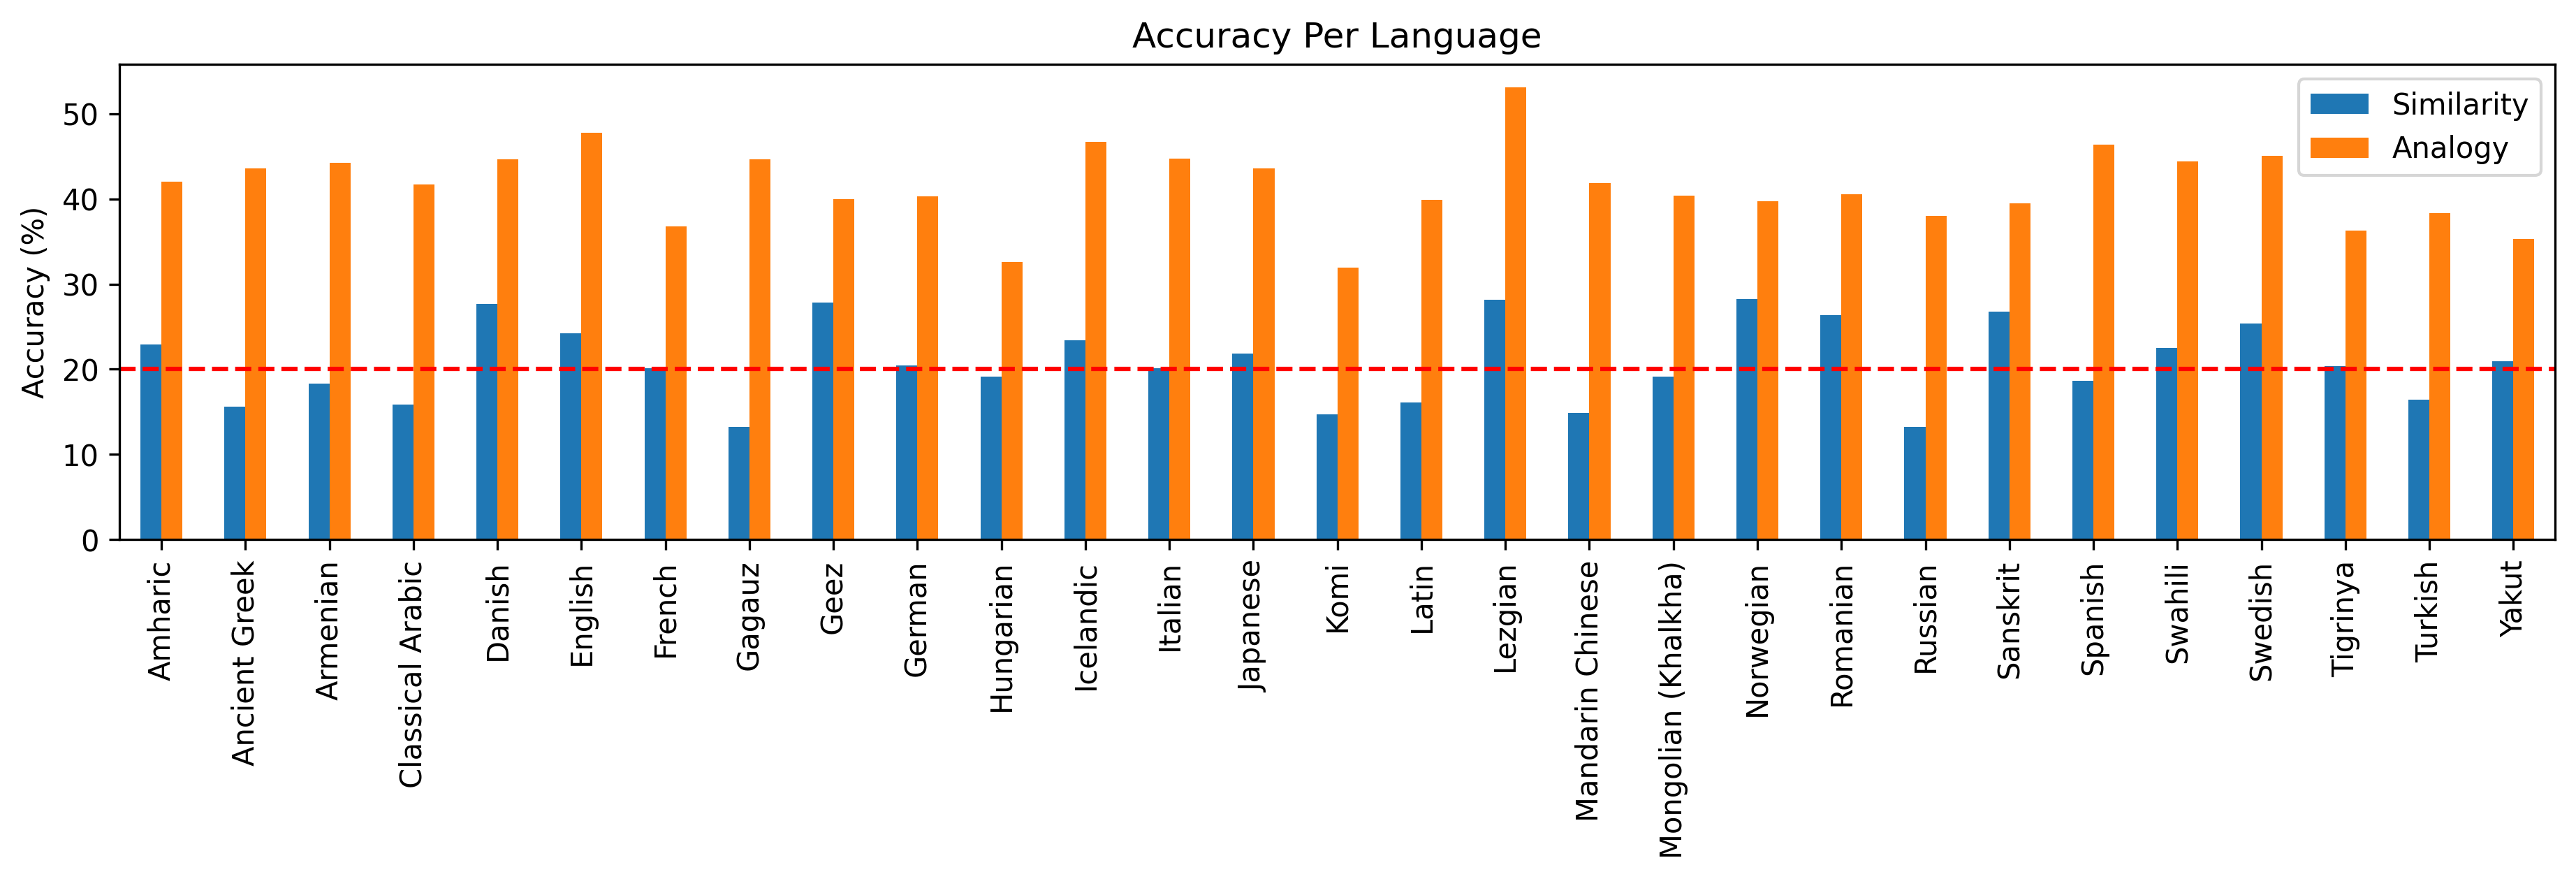

In [ ]:
# create the figure

ax = (accuracy_df[['sim_acc', 'analogy_acc']]*100).plot(kind='bar', figsize=(15, 3))
labels = accuracy_df['language'].values

# # Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy Per Language')
ax.set_xticks(np.arange(len(labels)), labels, rotation=90)
ax.legend(labels=['Similarity', 'Analogy'], bbox_to_anchor=(1, 1))
ax.axhline(20, linestyle='--', c='r')


plt.show()